<a href="https://colab.research.google.com/github/dowrave/Tensorflow_Basic/blob/main/220517_Training_Loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 훈련 루프
- 머신러닝 문제의 해결 과정
1. 훈련 데이터 얻기
2. 모델 정의하기 
3. 손실함수 정의하기
4. 훈련데이터 실행, 이상적인 값에서 손실 계산
5. 손실에 대한 기울기 계산 & 최적화하여 데이터에 맞게 변수 조정
6. 결과 평가

- 이번 예제는 f(x) = x*W + b 를 다룸

In [1]:
import tensorflow as tf

## 데이터
- 입력(X)와 출력(y, 가끔 레이블)
- tf에서 데이터의 각 입력은 거의 항상 텐서로 표현되며 벡터임. 출력값도 마찬가지


In [4]:
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000

x = tf.random.normal(shape = [NUM_EXAMPLES])
noise = tf.random.normal(shape = [NUM_EXAMPLES])

y = x * TRUE_W + noise

[]

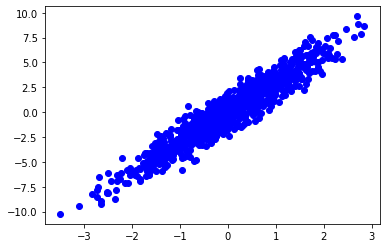

In [5]:
import matplotlib.pyplot as plt

plt.scatter(x, y, c= 'b')
plt.plot()

- 텐서는 일반적으로 batch 또는 입, 출력이 함께 쌓인 그룹의 형태로 수집된다.
- 일괄 처리는 몇 가지 훈련 이점이 있으며 가속기 또는 벡터화된 계산에서 잘 동작한다.
- 데이터세트가 충분히 작다면 전체 데이터 세트를 단일 배치로 처리할 수 있다.

## 모델 정의
- `tf.Variable`을 통해 모델의 모든 가중치를 나타낼 수 있다. 필요에 따라 텐서 형식도 제공함.
- `tf.Module`을 통해 변수, 계산을 캡슐화한다. 

In [6]:
# w, b를 변수로 저장함
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # 초기값 지정 - 케라스에서는 여러 초기화 함수를 제공하고 있음
    self.w = tf.Variable(5.)
    self.b = tf.Variable(0.)

  def __call__(self, x):
    return self.w * x + self.b

model = MyModel()

print("Variables  : ", model.variables)

assert model(3.).numpy() == 15.

Variables  :  (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


## 손실 함수 정의
- 여기선 평균 제곱 오류  = `L2 NORM`을 정의함

In [7]:
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))
  

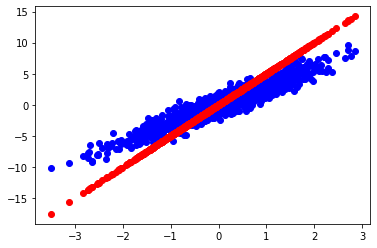

In [8]:
plt.scatter(x, y, c= 'b') # 파란 선 : 훈련 데이터
plt.scatter(x, model(x), c= 'r') # 붉은 선 : 모델의 예측
plt.show()

In [9]:
print("Currrent Loss : %1.6f" % loss(y, model(x)).numpy())

Currrent Loss : 5.057818


## 훈련 루프 정의
- 3가지 작업을 반복해서 수행한다.
  1. 모델을 통해 입력 배치 전송 & 출력 생성
  2. 출력을 출력(or 레이블)과 비교하여 손실 계산
  3. 그래디언트 테이프로 그래디언트 찾기
  4. 해당 그래디언트로 변수 최적화
- 예제에서는 경사 하강법을 이용함
- `tf.keras.optimizers`의 경사 하강법 체계에는 다양한 변형이 있다. 그러나 기본적인 수학을 직접 구현할 것이며, `tf.GradientTape`와 `tf.assign_sub`(`tf.assign` 및 `tf.sub`의 결합)을 이용한다.

In [11]:
def train(model, x, y ,learning_rate):
  with tf.GradientTape() as tape:
    current_loss = loss(y, model(x))

  dw, db = tape.gradient(current_loss, [model.w, model.b])

  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)


In [15]:
# 훈련 
model = MyModel()

Ws, bs = [], []
epochs = range(10)

def training_loop(model, x, y):
  for epoch in epochs:
    train(model, x, y, learning_rate = 0.1)

    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(y, model(x))

    print("Epoch %2d: W = %1.2f b = %1.2f, loss = %2.5f"%(epoch, Ws[-1], bs[-1], current_loss))


Starting : W = 5.00, b = 0.00, loss = 5.05782
Epoch  0: W = 4.59 b = 0.00, loss = 3.54661
Epoch  1: W = 4.26 b = 0.00, loss = 2.58928
Epoch  2: W = 4.00 b = 0.00, loss = 1.98283
Epoch  3: W = 3.80 b = 0.00, loss = 1.59865
Epoch  4: W = 3.63 b = 0.00, loss = 1.35528
Epoch  5: W = 3.50 b = -0.00, loss = 1.20110
Epoch  6: W = 3.40 b = -0.00, loss = 1.10343
Epoch  7: W = 3.31 b = -0.00, loss = 1.04155
Epoch  8: W = 3.25 b = -0.00, loss = 1.00236
Epoch  9: W = 3.19 b = -0.00, loss = 0.97753


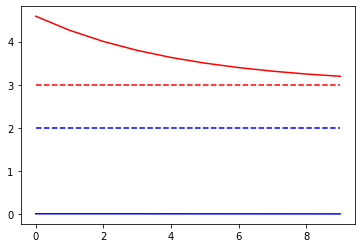

In [17]:
print("Starting : W = %1.2f, b = %1.2f, loss = %2.5f"%(model.w, model.b, loss(y, model(x))))

training_loop(model, x, y)

plt.plot(epochs, Ws, "r", epochs, bs, 'b') # 이런 문법이 되네?

plt.plot([TRUE_W] * len(epochs), 'r--', [TRUE_B] * len(epochs), 'b--')

plt.show()

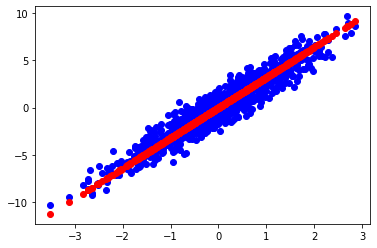

In [18]:
plt.scatter(x, y, c='b')
plt.scatter(x, model(x), c='r')
plt.show()

# 같은 코드를 케라스로 구현

In [21]:
class MyModelKeras(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.w = tf.Variable(5.)
    self.b = tf.Variable(0.)

  def call(self, x):
    return self.w * x + self.b

keras_model = MyModelKeras()

training_loop(keras_model, x, y)

# 케라스 빌트인 서포트로 checkpoint도 있다.
keras_model.save_weights("my_checkpoint")

Epoch  0: W = 4.59 b = 0.00, loss = 3.54661
Epoch  1: W = 4.26 b = 0.00, loss = 2.58928
Epoch  2: W = 4.00 b = 0.00, loss = 1.98283
Epoch  3: W = 3.80 b = 0.00, loss = 1.59865
Epoch  4: W = 3.63 b = 0.00, loss = 1.35528
Epoch  5: W = 3.50 b = -0.00, loss = 1.20110
Epoch  6: W = 3.40 b = -0.00, loss = 1.10343
Epoch  7: W = 3.31 b = -0.00, loss = 1.04155
Epoch  8: W = 3.25 b = -0.00, loss = 1.00236
Epoch  9: W = 3.19 b = -0.00, loss = 0.97753


- 파라미터를 사용하려면 `model.compile()`을 이용하여 매개변수를 설정, `model.fit()`을 사용하여 훈련할 수 있다.

In [23]:
keras_model = MyModelKeras()

keras_model.compile(
    # 기본 설정 : fit()은 tf.function()을 이용한다. 디버깅을 위해선 이를 끄는 게 좋음 - 근데 지금은 켬
    run_eagerly = False, # 즉 그래프 실행을 하겠다

    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1),

    # 이거 말고 위에서 정의한 손실함수를 써도 된다.
    loss = tf.keras.losses.mean_squared_error
)

In [24]:
print(x.shape[0])
keras_model.fit(x, y, epochs = 10, 
                batch_size = 1000) # 기본 배치는 32, 위의 텐서플로우 예제와 동일하게 하기 위해 1000으로 진행

1000
Epoch 1/10
1/1 [==============================] - 0s 308ms/step - loss: 5.0578
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 3.5466
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 2.5893
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 1.9828
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 1.5987
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 1.3553
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 1.2011
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 1.1034
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 1.0416
Epoch 10/10
1/1 [==============================] - 0s 5ms/step - loss: 1.0024


- 케라스의 loss는 기본적으로 훈련 후 손실을 보여주기 때문에 1번째 손실이 더 낮게 출력된다. 